<a href="https://colab.research.google.com/github/Srinidhi9113/GAN-MNIST/blob/main/GAN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize,Compose
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(),Normalize((0.5,),(0.5,))])
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor(),Normalize((0.5,),(0.5,))])
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11684693.64it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198225.64it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3668953.07it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20067171.93it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
from torch.utils.data import DataLoader

train_dl = DataLoader(training_data,
                      batch_size=128,
                      shuffle=True)

In [3]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [4]:
def denorm(img_tensors):
  return img_tensors*0.5+0.5

In [5]:
def show_images(images,nmax=64):
  fig,ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
  for images,label in dl:
    show_images(images,nmax)
    break

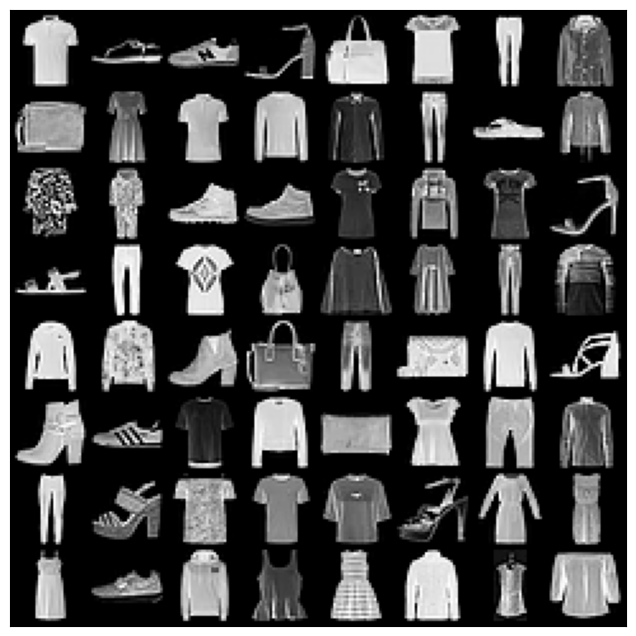

In [6]:
show_batch(train_dl)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Discriminator Network

In [8]:
import torch.nn as nn

In [9]:
discriminator = nn.Sequential(
    # 28*28
    nn.Conv2d(in_channels=1,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    # 14*14
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    # 7*7
    nn.Conv2d(in_channels=128,out_channels=512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    # 6*6
    nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=0,bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [10]:
discriminator.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Sigmoid()
)

## Generator Network

In [11]:
generator = nn.Sequential(
    nn.ConvTranspose2d(128,256,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=0,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=0,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,32,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32,1,kernel_size=4,stride=1,padding=0,bias=False),
    nn.Tanh()
)

In [12]:
generator.to(device)

Sequential(
  (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Tanh()
)

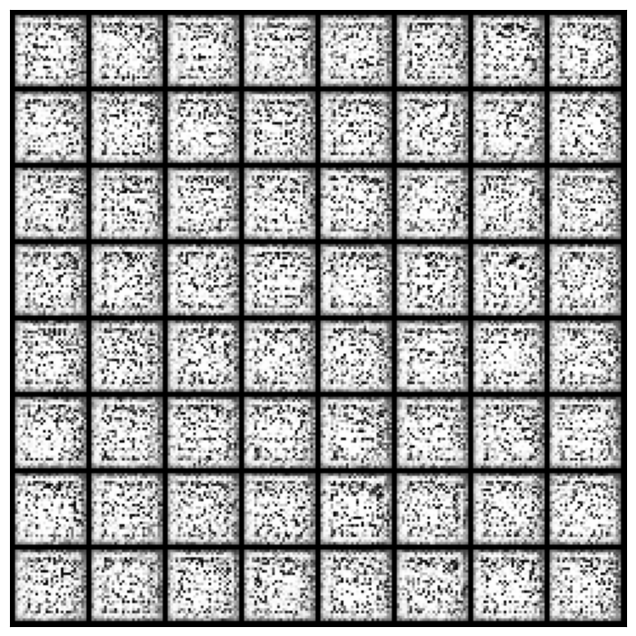

In [13]:
input_tensor = torch.randn(128,128,1,1).to(device)
fake_images = generator(input_tensor)
show_images(fake_images.to("cpu"))

In [14]:
fake_images.shape

torch.Size([128, 1, 28, 28])

In [15]:
discriminator(fake_images).shape

torch.Size([128, 1])

## Discriminator Training

In [16]:
import torch.nn.functional as F

* Discriminator predicts 1 if image is picked from MNIST dataset, 0 otherwise

In [17]:
def train_discriminator(real_images,opt_d):
  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1,device=device)
  real_loss = F.binary_cross_entropy(real_preds,real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(128,128,1,1,device=device)
  fake_images = generator(latent)

  fake_targets = torch.zeros(fake_images.size(0),1,device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss+fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

## Generator Training

In [18]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(128,128,1,1,device=device)
  fake_images = generator(latent)

  fake_preds = discriminator(fake_images)
  fake_targets = torch.ones(fake_images.size(0),1,device=device)
  loss = F.binary_cross_entropy(fake_preds,fake_targets)

  loss.backward()
  opt_g.step()

  return loss.item()


In [19]:
from torchvision.utils import save_image
import os

In [20]:
sample_dir = "generated"
os.makedirs(sample_dir,exist_ok=True)

In [21]:
def save_samples(index,latent_tensors,show=True):
  fake_images = generator(latent_tensors)
  fake_fname = "generated-images-{0:0=4d}.png".format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
  print("Saving",fake_fname)
  if show:
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [22]:
fixed_latent = torch.randn(64,128,1,1,device=device)

Saving generated-images-0000.png


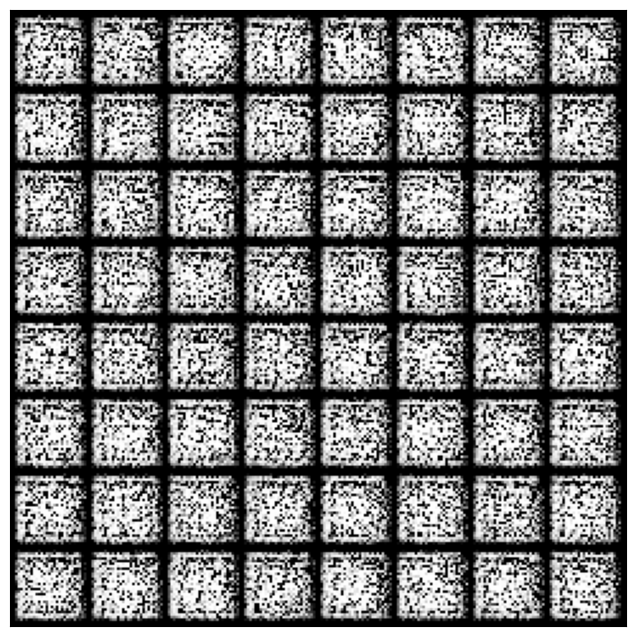

In [23]:
save_samples(0,fixed_latent)

## Overall Training Loop

In [24]:
from tqdm.auto import tqdm
import torch.nn.functional as F

In [25]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b,_ in self.dl:
      yield b.to(self.device)

  def __len__(self):
    return len(self.dl)

In [26]:
train_dl = DeviceDataLoader(train_dl,device)

In [27]:
def fit(epochs,lr,start_idx=1):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(),
                           lr,
                           betas=(0.5,0.999))
  opt_g = torch.optim.Adam(generator.parameters(),
                           lr,
                           betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images in tqdm(train_dl):
      loss_d,real_score,fake_score = train_discriminator(real_images,opt_d)
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch,epochs,loss_g,loss_d,real_score,fake_score))

    save_samples(epoch+start_idx,fixed_latent,show=False)

  return losses_g,losses_d,real_scores,fake_scores

In [28]:
lr = 0.0002
epochs = 12

In [29]:
history = fit(epochs,lr)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [0/12], loss_g: 7.9530, loss_d: 0.0012, real_score: 0.9994, fake_score: 0.0006
Saving generated-images-0001.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/12], loss_g: 4.7802, loss_d: 0.0871, real_score: 0.9524, fake_score: 0.0282
Saving generated-images-0002.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/12], loss_g: 5.4097, loss_d: 0.6146, real_score: 0.9464, fake_score: 0.3730
Saving generated-images-0003.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/12], loss_g: 3.6712, loss_d: 0.2434, real_score: 0.8423, fake_score: 0.0449
Saving generated-images-0004.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/12], loss_g: 2.7936, loss_d: 0.8588, real_score: 0.8869, fake_score: 0.4338
Saving generated-images-0005.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/12], loss_g: 2.1961, loss_d: 0.7842, real_score: 0.8260, fake_score: 0.3820
Saving generated-images-0006.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/12], loss_g: 3.1832, loss_d: 0.6571, real_score: 0.8652, fake_score: 0.3394
Saving generated-images-0007.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/12], loss_g: 2.5892, loss_d: 0.6062, real_score: 0.7699, fake_score: 0.2363
Saving generated-images-0008.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/12], loss_g: 2.5725, loss_d: 0.6728, real_score: 0.8838, fake_score: 0.3509
Saving generated-images-0009.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/12], loss_g: 2.0092, loss_d: 0.4690, real_score: 0.7165, fake_score: 0.0730
Saving generated-images-0010.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/12], loss_g: 2.3415, loss_d: 0.4741, real_score: 0.8285, fake_score: 0.2144
Saving generated-images-0011.png


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [11/12], loss_g: 1.6482, loss_d: 1.0620, real_score: 0.4189, fake_score: 0.0308
Saving generated-images-0012.png
